In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
  img {margin-left: 0 !important;}
  table td, table th, table tr {text-align:left !important;}
</style>

# Koalas: Simplifying PySpark with Pandas

<img src="https://files.training.databricks.com/images/fire-koala.jpg" width=150 > 

This notebook provides a sample example of scaling your machine learning using [Koalas: Pandas API on Apache Spark](https://github.com/databricks/koalas).

Pandas is the de facto standard (single-node) dataframe implementation in Python, while Apache Spark is the de facto standard for big data processing. We can use Koalas to:

* Use Pandas (in lieu of PySpark) syntax
* Easily scale your machine learning utilizing Apache Spark with Pandas syntax

For more information:
* [Koalas Documentation](https://koalas.readthedocs.io/)
* [Koalas GitHub Repo](https://github.com/databricks/koalas)
* [koalas (PyPI)](https://pypi.org/project/koalas/)
    

In [2]:
import pandas as pd
import pyspark
import databricks.koalas as ks

## Data Source
We will start by reading in the [Kaggle Boston Housing dataset](https://www.kaggle.com/c/boston-housing/data).

![](https://storage.googleapis.com/kaggle-competitions/kaggle/5315/logos/front_page.png)

#### Housing Values in Suburbs of Boston
The medv variable is the target variable.

#### Data description
The Boston data frame has 506 rows and 14 columns.

This data frame contains the following columns:

| columns | description |
| :------ | :---------- |
|crim |  per capita crime rate by town. |
| zn | proportion of residential land zoned for lots over 25,000 sq.ft. |
| indus | proportion of non-retail business acres per town. |
| chas |  Charles River dummy variable (= 1 if tract bounds river; 0 otherwise). |
| nox |  nitrogen oxides concentration (parts per 10 million). |
| rm | average number of rooms per dwelling. |
| age |  proportion of owner-occupied units built prior to 1940. |
| dis |  weighted mean of distances to five Boston employment centres. |
| rad |  index of accessibility to radial highways. |
| tax | full-value property-tax rate per \$10,000. |
| ptratio | pupil-teacher ratio by town. |
| black | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town. |
| lstat | lower status of the population (percent). |
| medv | median value of owner-occupied homes in \$1000s. |

#### Sources:
* Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.
* Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.

#### Resources:
* A great more indepth blog post is Susan Li's [Building A Linear Regression with PySpark and MLlib](https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a)

In [3]:
# Configure file path
file_path = './boston-housing.csv'

## Load Data Using Pandas Syntax via Koalas
We can load our data using the Pandas syntax `.read_csv()` to read the CSV file and use the Pandas syntax `.head()` to review the top 5 rows of our Spark DataFrame.

In [4]:
# Use `read_csv` to read the CSV file
kdf = ks.read_csv(file_path)

# Use Pandas `.head` syntax
kdf.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


## Exploratory Data Analysis
We will use a combination of `matplotlib` and `koalas` to review our data.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
import seaborn as sns

Convert a `koalas` DataFrame to a `pandas` DataFrame via `toPandas()`

In [6]:
# Convert koalas DataFrame to pandas DataFrame via `toPandas()`
pdf = kdf.toPandas()

Let's use the `pandas.plotting.scatter_matrix` to determine if we have any correlations between these variables.

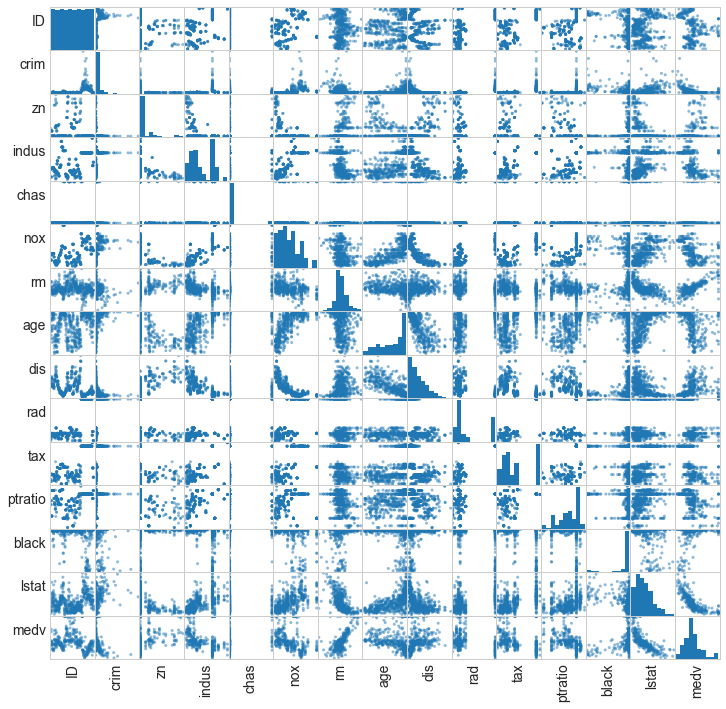

In [7]:
axs = pd.plotting.scatter_matrix(pdf, figsize=(12, 12))
n = len(pdf.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.yaxis.label.set_size(14)
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.xaxis.label.set_size(14)
    h.set_xticks(())

### `rm` and `medv`
In the above scatterplot, you can see a possible correlation between `rm` (average rooms per dwelling) and `medv` (median value of owner-occupied homes).  This can be better seen in the following scatterplot of just these two variables.

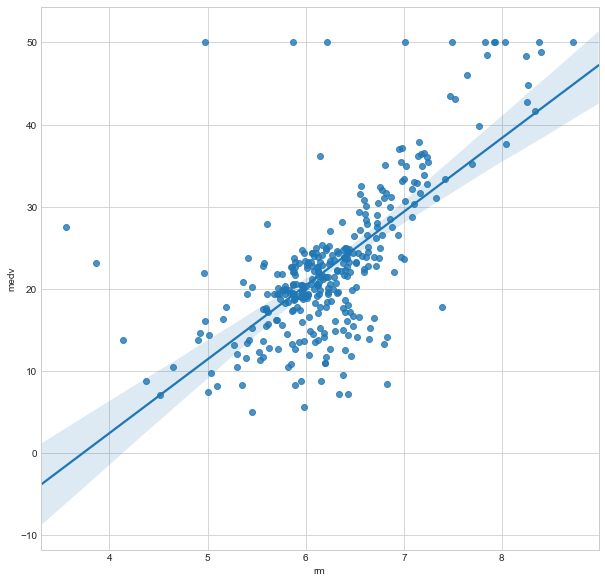

In [8]:
plt.figure(figsize=(10, 10))
sns.regplot(x="rm", y="medv", data=pdf)

### `lstat` and `medv`
In the above scatterplot, you can see a possible negative linear correlation between `lstat` (lower status of population) and `medv` (median value of owner-occupied homes).  This can be better seen in the following scatterplot of just these two variables.

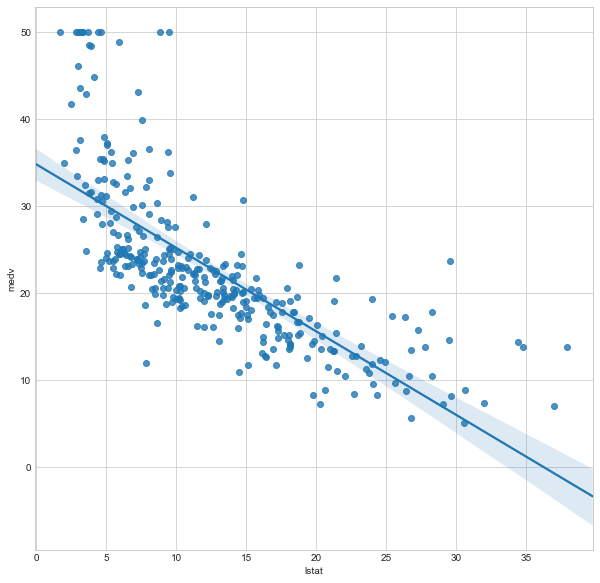

In [9]:
plt.figure(figsize=(10, 10))
sns.regplot(x="lstat", y="medv", data=pdf)

### Use Pandas `.corr` to Calculate Correlation Coefficents 
We can quickly calculate the correlation matrix of all attributes with `medv` using Pandas `.corr`.  We plot a diagonal correlation matrix using `seaborn`; refer to [plotting a diagonal correlation matrix](https://seaborn.pydata.org/examples/many_pairwise_correlations.html) for more information.

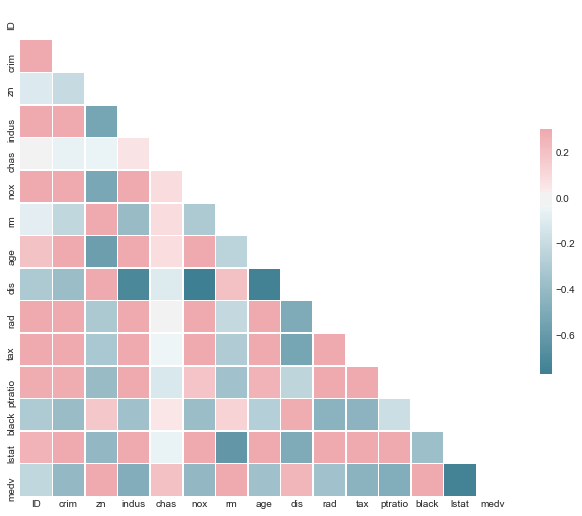

In [10]:
# Calculate using Pandas `corr`
pdf_corr = pdf.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.zeros_like(pdf_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pdf_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

 ## Use Koalas for Pandas Syntax
* Drop rows with missing values via `.dropna()`
* Rename columns using `.columns`

In [11]:
# drop rows with missing values
kdf = kdf.dropna()  
kdf.count()

ID         333
crim       333
zn         333
indus      333
chas       333
nox        333
rm         333
age        333
dis        333
rad        333
tax        333
ptratio    333
black      333
lstat      333
medv       333
dtype: int64

In [12]:
# New column names
column_names = ['ID', 'crime', 'zone', 'industry', 'bounds_river', 'nox', 'rooms', 'age', 'distance', 'radial_highway', 'tax', 'pupil_teacher', 'black_proportion', 'lower_status', 'median_value']

# Rename columns
kdf.columns = column_names

## Choosing Features
Reviewing the correlation coefficient matrix and scatterplots, let's choose features that have slighty stronger positive or negative correlation to the `median_value` where `abs(correlation coefficients) >= 0.4`.

In [13]:
# Limit feature columns to abs(correlation coefficients) >= 0.4 
featureColumns = ['crime', 'industry', 'nox', 'rooms', 'tax', 'pupil_teacher', 'lower_status']

## Build our Linear Regression Model

Let's build our Linear Regression model using Scikit-Learn.

In [14]:
# Re-generate Pandas DataFrame from updated Koala DataFrame
pdf = kdf.toPandas()

# Split training and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pdf[featureColumns].values, pdf['median_value'].values, test_size=0.20, random_state=567248)

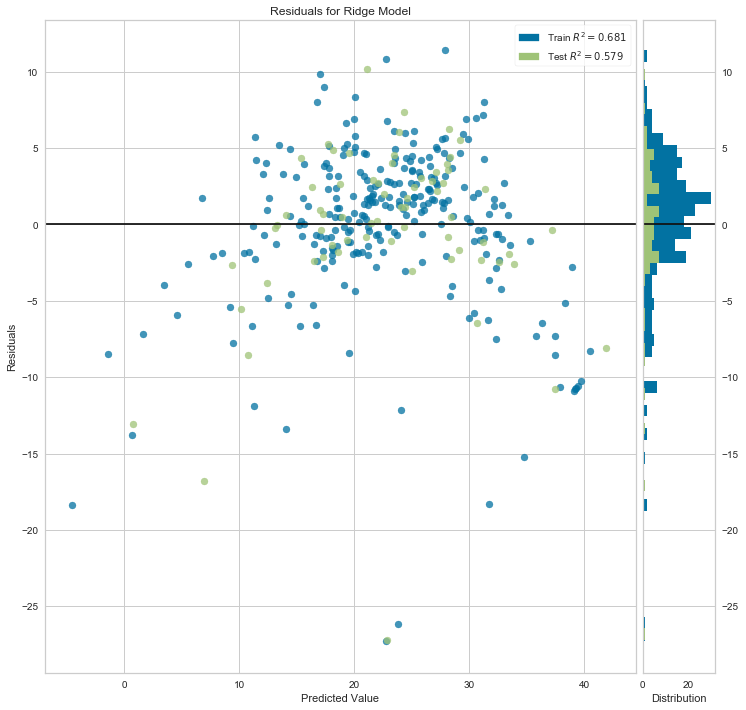

In [17]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Set figure size
plt.figure(figsize=(12, 12))

# Instantiate the linear model and visualizer
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()             # Draw/show/poof the data

## Discussion
While this is a small dataset example, as you increase the iterations and/or data sizes by using `koalas`.  While there is great functionality with the `pandas` syntax, it can be at times very slow.  But with `koalas`, you can easily scale the same code while using PySpark in the backend.